In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import statsmodels as sm



### Import csv

In [3]:
filename = './data/ML_IGE_ENTRANTS_MODELE1.csv'

In [4]:
df = pd.read_csv(filename,sep=';',engine='python',index_col='DATEDATA',parse_dates=True)

In [5]:
df.head()

,SITE,CLIENT,FLUX_ACTIVITE,SECTEUR_ACTIVITE,SERVICE_ACTIVITE,MEDIA,TYPEDOSSIER,REGROUPEMENTTDB,TOTAL
DATEDATA,,,,,,,,,
2019-09-18,COURBEVOIE,BCAC,Flux Décès,Prévoyance,PREVOYANCE,Email,Ouverture dossier Décès,Dossiers Prévoyance,4
2019-12-02,COURBEVOIE,BCAC,Flux Prestation,Prestations,PRESTATION,LR/AR,Prestations,Dossiers Prestations,4
2020-01-06,MARSEILLE,ISTYACO GESTION,Flux Noemie,EDI,CONTRAT - COTISATION,Appel,Echanges Noémie,Dossiers EDI,2
2019-08-29,MARSEILLE,ISTYACO GESTION,Flux Devis,Prestations,PRESTATION,Courrier,Devis dentaire,Dossiers Devis,4
2018-08-07,VELIZY,KLESIA PREVOYANCE,Flux Cotisation,Contrats- Cotisations,CONTRAT - COTISATION,Appel,Cotisations individuelles,Dossiers Cotisations,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378795 entries, 2019-09-18 to 2019-08-06
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   SITE              378795 non-null  object
 1   CLIENT            378787 non-null  object
 2   FLUX_ACTIVITE     378795 non-null  object
 3   SECTEUR_ACTIVITE  378795 non-null  object
 4   SERVICE_ACTIVITE  378795 non-null  object
 5   MEDIA             335016 non-null  object
 6   TYPEDOSSIER       378795 non-null  object
 7   REGROUPEMENTTDB   378795 non-null  object
 8   TOTAL             378795 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 28.9+ MB


### preprocess columns

In [7]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [157]:
df[:10]

,SITE,CLIENT,FLUX_ACTIVITE,SECTEUR_ACTIVITE,SERVICE_ACTIVITE,MEDIA,TYPEDOSSIER,REGROUPEMENTTDB,TOTAL
DATEDATA,,,,,,,,,
2019-09-18,COURBEVOIE,BCAC,Flux Décès,Prévoyance,PREVOYANCE,Email,Ouverture dossier Décès,Dossiers Prévoyance,4
2019-12-02,COURBEVOIE,BCAC,Flux Prestation,Prestations,PRESTATION,LR/AR,Prestations,Dossiers Prestations,4
2020-01-06,MARSEILLE,ISTYACO GESTION,Flux Noemie,EDI,CONTRAT - COTISATION,Appel,Echanges Noémie,Dossiers EDI,2
2019-08-29,MARSEILLE,ISTYACO GESTION,Flux Devis,Prestations,PRESTATION,Courrier,Devis dentaire,Dossiers Devis,4
2018-08-07,VELIZY,KLESIA PREVOYANCE,Flux Cotisation,Contrats- Cotisations,CONTRAT - COTISATION,Appel,Cotisations individuelles,Dossiers Cotisations,1
2019-02-06,VELIZY,KLESIA - MUTUELLE GEODIS,Flux BAE-BIA,Contrats- Cotisations,CONTRAT - COTISATION,Email,Adhésion - Portabilité,Dossiers Contractuels,3
2018-09-04,VELIZY,KLESIA PREVOYANCE,Flux BAE-BIA,Contrats- Cotisations,CONTRAT - COTISATION,Appel,Adhésions - Ajout de bénéficiaires,Dossiers Contractuels,2
2018-09-12,MARSEILLE,ISTYACO GESTION,Flux Prestation,Prestations,PRESTATION,Email,Factures Optiques,Dossiers Prestations,11
2019-09-30,VELIZY,KLESIA PREVOYANCE,Flux Prestation,Prestations,PRESTATION,Email,Factures Optiques,Dossiers Prestations,2


### Filter

In [160]:
def filter_df(df, mydict):
    df_filter = df.copy()
    for key,value in mydict.items():
        df_filter = df_filter[df_filter[key]==value]
    return df_filter
    
    
myfilters = {'SITE':'VELIZY','FLUX_ACTIVITE':'Flux Prestation','SERVICE_ACTIVITE':'PRESTATION','MEDIA':'Courrier'}
df_filter = filter_df(df, myfilters)

In [161]:
df_filter

,SITE,CLIENT,FLUX_ACTIVITE,SECTEUR_ACTIVITE,SERVICE_ACTIVITE,MEDIA,TYPEDOSSIER,REGROUPEMENTTDB,TOTAL
DATEDATA,,,,,,,,,
2019-01-07,VELIZY,KLESIA - MUTUELLE GEODIS,Flux Prestation,Prestations,PRESTATION,Courrier,Prestations,Dossiers Prestations,48
2020-01-13,VELIZY,MUTUELLE DU PERSONNEL DU GROUPE SOCIETE GENERALE,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Hospitalisation,Dossiers Prestations,90
2018-10-24,VELIZY,KLESIA PREVOYANCE,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Dentaires,Dossiers Prestations,5
2019-06-05,VELIZY,KLESIA - MUTUELLE GEODIS,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Hospitalisation,Dossiers Prestations,5
2019-11-27,VELIZY,K2 - MUTUELLE D'ENTRAIDE DE LA MUTUALITE FRANÇ...,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Dentaires,Dossiers Prestations,2
...,...,...,...,...,...,...,...,...,...
2019-01-22,VELIZY,K2 - MUTUELLE FAMILIALE DES CHEMINOTS DE FRANCE,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Optiques,Dossiers Prestations,4
2020-02-07,VELIZY,K2 - MUTUELLE DE NATIXIS,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Optiques,Dossiers Prestations,1
2019-09-06,VELIZY,MUTUELLE DU PERSONNEL DU GROUPE SOCIETE GENERALE,Flux Prestation,Prestations,PRESTATION,Courrier,Factures Dentaires,Dossiers Prestations,93


### Create Aggregated Df with DatTime Index

In [162]:
df2 = df_filter.groupby('DATEDATA').sum()
df2 = df2.asfreq(freq='B')

In [163]:
df2

,TOTAL
DATEDATA,
2018-08-01,499
2018-08-02,1045
2018-08-03,733
2018-08-06,753
2018-08-07,919
...,...
2020-06-17,307
2020-06-18,2144
2020-06-19,630


### Split in train test to compare with predictions

In [180]:
from pmdarima.model_selection import train_test_split

testsize = 90

train,test = train_test_split(df2, test_size=testsize)

### Look at train dataset

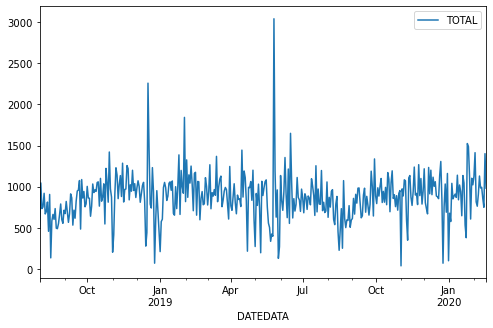

In [181]:
plt.rcParams['figure.figsize'] = [8, 5]
train.plot();

In [182]:
# from scipy.stats import boxcox

# df3, l = boxcox(train['TOTAL'])

In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 405 entries, 2018-08-01 to 2020-02-18
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TOTAL   405 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


In [184]:
train = train.copy()
train['TOTAL'].fillna(0,inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 405 entries, 2018-08-01 to 2020-02-18
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TOTAL   405 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


In [185]:
test = test.copy()
test['TOTAL'].fillna(0,inplace=True)

### Decompose

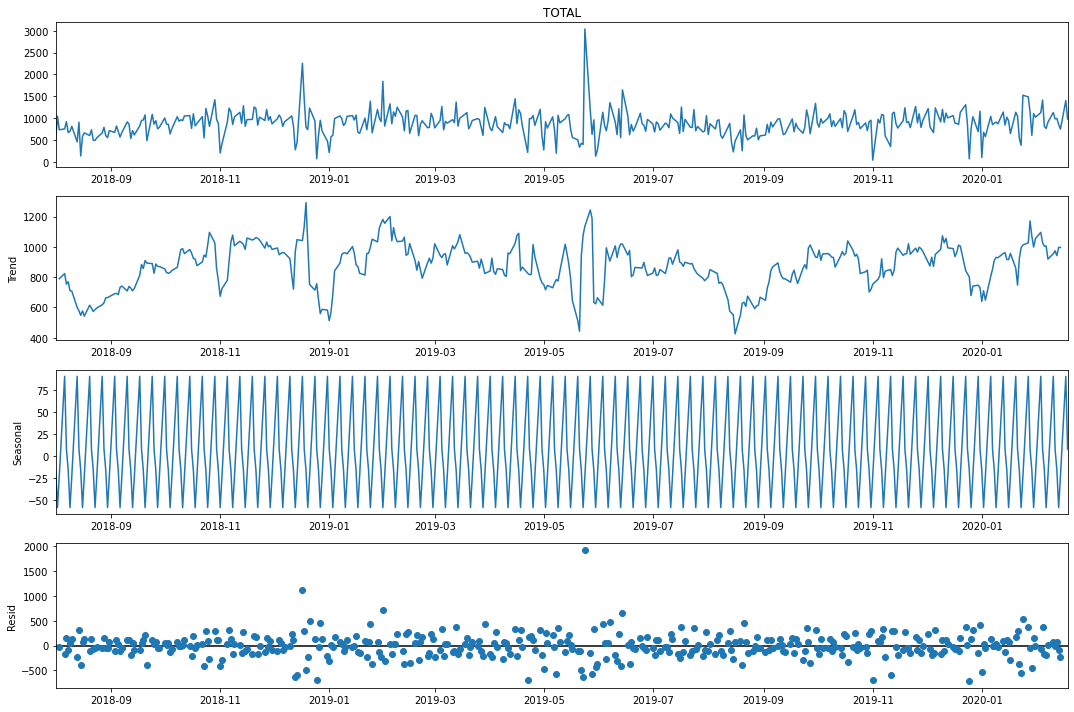

In [186]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train.TOTAL.interpolate(),period=5, model='add')
plt.rcParams['figure.figsize'] = [15, 10]
resplot = res.plot()

### ACF / PACF

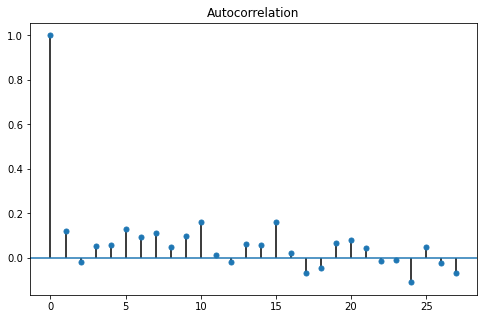

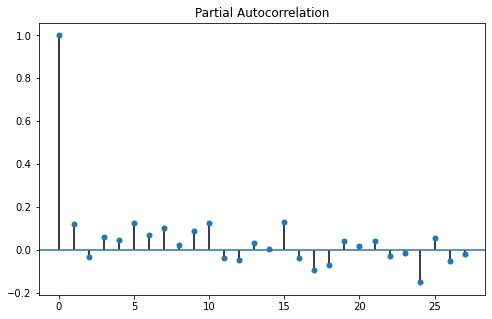

In [187]:
from pmdarima import utils
plt.rcParams['figure.figsize'] = [8, 5]
utils.plot_acf(train)
utils.plot_pacf(train)

In [188]:
# Fit a simple auto_arima model
import pmdarima as pm
modl = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=5)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,5) [intercept=True]; AIC=5848.586, BIC=5880.617, Time=0.415 seconds
Fit ARIMA(0,0,0)x(0,0,0,5) [intercept=True]; AIC=5743.787, BIC=5751.795, Time=0.018 seconds
Fit ARIMA(1,0,0)x(1,0,0,5) [intercept=True]; AIC=5738.412, BIC=5754.427, Time=0.334 seconds
Fit ARIMA(0,0,1)x(0,0,1,5) [intercept=True]; AIC=5737.000, BIC=5753.015, Time=0.266 seconds
Fit ARIMA(0,0,0)x(0,0,0,5) [intercept=False]; AIC=6679.087, BIC=6683.090, Time=0.012 seconds
Fit ARIMA(0,0,1)x(0,0,0,5) [intercept=True]; AIC=5739.381, BIC=5751.393, Time=0.050 seconds
Fit ARIMA(0,0,1)x(1,0,1,5) [intercept=True]; AIC=5782.493, BIC=5802.512, Time=0.239 seconds
Fit ARIMA(0,0,1)x(0,0,2,5) [intercept=True]; AIC=5733.109, BIC=5753.129, Time=0.320 seconds
Fit ARIMA(0,0,1)x(1,0,2,5) [intercept=True]; AIC=9707.875, BIC=9731.899, Time=0.350 seconds
Fit ARIMA(0,0,0)x(0,0,2,5) [intercept=True]; AIC=5735.988, BIC=5752.004, Time=0.280 seconds
Fit ARIMA(1,0,1)x(0,0,2,5) [intercep

In [189]:
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  405
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 5)   Log Likelihood               -2861.555
Date:                                Fri, 26 Jun 2020   AIC                           5733.109
Time:                                        11:16:27   BIC                           5753.129
Sample:                                             0   HQIC                          5741.033
                                                - 405                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    870.5266     22.306     39.026      0.000     826.807     914.246
ma.L1          0.1280      0.059      2.184      0.029       0.013       0.243
ma.S.L5        0.0743      0.039      1.905      0.057      -0.002       0.151
ma.S.L10       0.1169      0.053      2.222      0.026       0.014       0.220
sigma2      8.264e+04   2827.809     29.223      0.000    7.71e+04    8.82e+04
===================================================================================
Ljung-Box (Q):                       48.86   Jarque-Bera (JB):              2155.00
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.32
Prob(H) (two-sided):                  0.30   Kurtosis:                        13.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

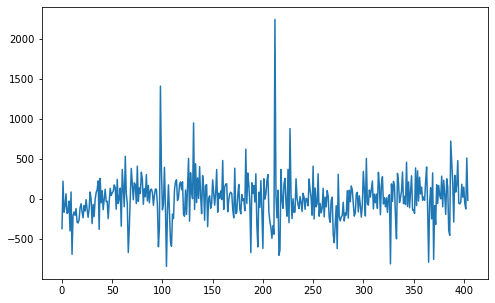

In [190]:
plt.plot(modl.resid())

In [191]:
from sklearn.metrics import mean_squared_error
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 476.716


In [192]:
graph = test.copy()
graph = graph.rename(columns={'TOTAL':'TEST'})
graph['preds'] = preds
graph['lb'] = conf_int[:,0]
graph['ub'] = conf_int[:,1]
graph = graph.append(train)

In [195]:
# graph = graph.sort_index()
graphz = graph[graph.index>'2018-06-01']

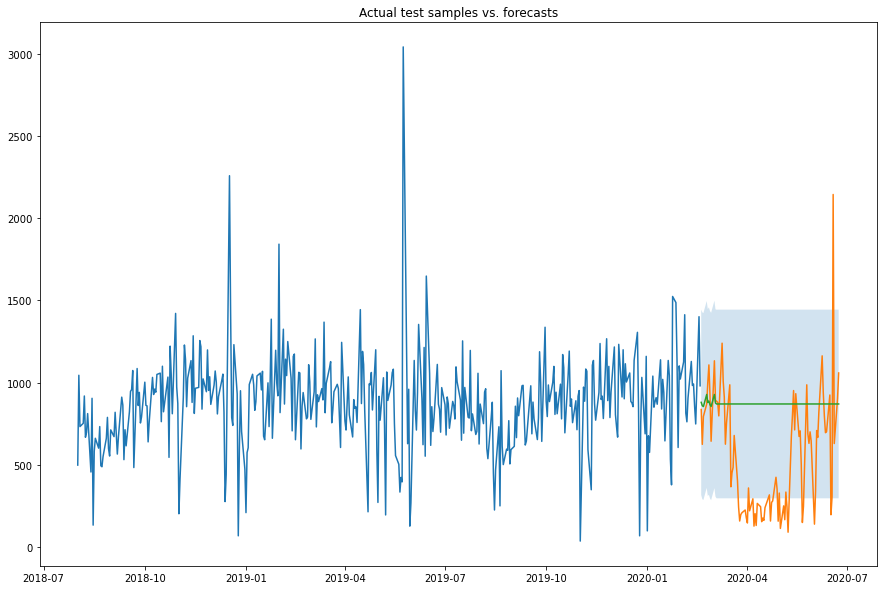

In [196]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(graphz.index, graphz.TOTAL)
plt.plot(graphz.index, graphz.TEST)
plt.plot(graphz.index, graphz.preds)
plt.fill_between(graphz.index,graphz.lb,graphz.ub,alpha=.2)
plt.title('Actual test samples vs. forecasts')
plt.show()